In [1]:
print('Importing packages...')
import os
import urllib
import pandas
import zipfile
import time
import numpy as np
from matplotlib import pyplot as plt
import geopandas as gpd
from IPython.display import display, HTML
from matplotlib import ticker as ticker

#data_dir = '/home/idies/workspace/Temporary/raddick/cra_scratch'
shapefiledir = '/home/idies/workspace/Storage/raddick/Baltimore/shapefiles/'

thisdir = '/home/idies/workspace/Storage/raddick/Baltimore/community_reinvestment_act'
datadir = thisdir + '/datasets'
figdir = thisdir + '/figures'

os.chdir(thisdir)
os.getcwd()

Importing packages...


'/home/idies/workspace/Storage/raddick/Baltimore/community_reinvestment_act'

In [ ]:
# Unit of analysis: census tract
# DV: nLoans1, amtLoans1, etc. Also: (overall minus "credit card loans")
#### where credit card loans" are <$100k to businesses with <$10k budget

# IV: [population by race; owner-occupied units; MFI; hs grad pct; 
### female hoh pct; unemployment pct; poverty pct; median home value;
### median home year built

# Get CRA data by census tract (from aggregate files)

In [2]:
cra_data_by_tract_year_df = pandas.read_csv(datadir+'/loans_by_census_tract_2010_2016.csv')
cra_data_by_tract_year_df = cra_data_by_tract_year_df.set_index(['census_tract','activity_year'])
cra_data_by_tract_year_df.index.name = ['census_tract','activity_year']

for thiscol in ['amtLoans1', 'amtLoans100k', 'amtLoans250k', 'amtLoansToSmallest', 'amtLoansTotal']:
    cra_data_by_tract_year_df[thiscol] = pandas.to_numeric(cra_data_by_tract_year_df[thiscol].apply(lambda x: x[1:].replace(',','')), errors='coerce')

cra_data_by_tract_year_df = cra_data_by_tract_year_df.assign(income_group = np.nan)
cra_data_by_tract_year_df.loc[cra_data_by_tract_year_df['income_group_code'] == 1, 'income_group'] = '< 10% of Median Family Income (MFI)'
cra_data_by_tract_year_df.loc[cra_data_by_tract_year_df['income_group_code'] == 2, 'income_group'] = '10% to 20% of MFI'
cra_data_by_tract_year_df.loc[cra_data_by_tract_year_df['income_group_code'] == 3, 'income_group'] = '20% to 30% of MFI'
cra_data_by_tract_year_df.loc[cra_data_by_tract_year_df['income_group_code'] == 4, 'income_group'] = '30% to 40% of MFI'
cra_data_by_tract_year_df.loc[cra_data_by_tract_year_df['income_group_code'] == 5, 'income_group'] = '40% to 50% of MFI'
cra_data_by_tract_year_df.loc[cra_data_by_tract_year_df['income_group_code'] == 6, 'income_group'] = '50% to 60% of MFI'
cra_data_by_tract_year_df.loc[cra_data_by_tract_year_df['income_group_code'] == 7, 'income_group'] = '60% to 70% of MFI'
cra_data_by_tract_year_df.loc[cra_data_by_tract_year_df['income_group_code'] == 8, 'income_group'] = '70% to 80% of MFI'
cra_data_by_tract_year_df.loc[cra_data_by_tract_year_df['income_group_code'] == 9, 'income_group'] = '80% to 90% of MFI'
cra_data_by_tract_year_df.loc[cra_data_by_tract_year_df['income_group_code'] == 10, 'income_group'] = '90% to 100% of MFI'
cra_data_by_tract_year_df.loc[cra_data_by_tract_year_df['income_group_code'] == 11, 'income_group'] = '100% to 110% of MFI'
cra_data_by_tract_year_df.loc[cra_data_by_tract_year_df['income_group_code'] == 12, 'income_group'] = '110% to 120% of MFI'
cra_data_by_tract_year_df.loc[cra_data_by_tract_year_df['income_group_code'] == 13, 'income_group'] = '> 120% of MFI'

cra_data_by_tract_year_df = cra_data_by_tract_year_df.assign(income_level = np.nan)
cra_data_by_tract_year_df.loc[cra_data_by_tract_year_df['income_group_code'] <= 5, 'income_level'] = 'low'
cra_data_by_tract_year_df.loc[(cra_data_by_tract_year_df['income_group_code'] >= 6) & (cra_data_by_tract_year_df['income_group_code'] <= 8), 'income_level'] = 'moderate'
cra_data_by_tract_year_df.loc[(cra_data_by_tract_year_df['income_group_code'] >= 9) & (cra_data_by_tract_year_df['income_group_code'] <= 12), 'income_level'] = 'middle'
cra_data_by_tract_year_df.loc[cra_data_by_tract_year_df['income_group_code'] == 13, 'income_level'] = 'high'

#cra_data_by_tract_year_df.groupby(['income_group_code','income_group', 'income_level']).size()#.dtypes

print('Backing up...')
cra_data_by_tract_year_df_bk = cra_data_by_tract_year_df

cra_data_by_tract_year_df.sample(2)

Backing up...


,,income_group_code,nLoans1,amtLoans1,nLoans100k,amtLoans100k,nLoans250k,amtLoans250k,nLoansToSmallest,amtLoansToSmallest,nLoansTotal,amtLoansTotal,income_group,income_level
census_tract,activity_year,,,,,,,,,,,,,
104.00,2014,13,97,1567000,7,1506000,9,4699000,53,3368000,113,7772000,> 120% of MFI,high
2501.01,2014,8,18,133000,0,0,0,0,13,94000,18,133000,70% to 80% of MFI,moderate


## Add CSA information

In [3]:
print('Reading from backup...')
cra_data_by_tract_year_df = cra_data_by_tract_year_df_bk

tract_to_csa_df = pandas.read_csv('census_tract_to_neighborhood.csv')
tract_to_csa_df = tract_to_csa_df.set_index('NAME10')

cra_data_by_tract_year_df = cra_data_by_tract_year_df.assign(CSA2010 = cra_data_by_tract_year_df.join(tract_to_csa_df, how='left', on='census_tract')['CSA2010'])

print('Backing up...')
cra_data_by_tract_year_df_bk = cra_data_by_tract_year_df

cra_data_by_tract_year_df.sample(2)

Reading from backup...
Backing up...


,,income_group_code,nLoans1,amtLoans1,nLoans100k,amtLoans100k,nLoans250k,amtLoans250k,nLoansToSmallest,amtLoansToSmallest,nLoansTotal,amtLoansTotal,income_group,income_level,CSA2010
census_tract,activity_year,,,,,,,,,,,,,,
1510.0,2010,6,9,64000,0,0,1,700000,3,702000,10,764000,50% to 60% of MFI,moderate,Dorchester/Ashburton
1702.0,2010,3,1,3000,0,0,0,0,0,0,1,3000,20% to 30% of MFI,low,Upton/Druid Heights


## Get shapefile and connect with aggregate loan data

In [4]:
print('Reading CRA data from backup...\n')
cra_data_by_tract_year_df = cra_data_by_tract_year_df_bk

s = time.time()
print('reading shapefiles...')
tract_shapes_gdf = gpd.read_file(shapefiledir+'census_tracts_2010/geo_export_c50bbe56-543e-4878-9c9f-c56be327600a.shp', encoding='utf-8')
tract_shapes_gdf = tract_shapes_gdf.assign(tractname = pandas.to_numeric(tract_shapes_gdf['name'].apply(lambda x: x.split(' ')[-1]), errors='coerce'))
tract_shapes_gdf = tract_shapes_gdf.set_index('tractname')
tract_shapes_gdf.index.name = 'census_tract'

print('Keeping only census tract shapes...')
tract_shapes_gdf = tract_shapes_gdf['geometry']

e = time.time()
print('Processed {0:,.0f} Maryland census tracts in {1:.3f} seconds...'.format(len(tract_shapes_gdf), e-s))

print('\nAdding shape data to aggregate loan data...')
cra_data_by_tract_year_df = cra_data_by_tract_year_df.join(tract_shapes_gdf, how='left')

print('backing up...')
cra_data_by_tract_year_df_bk = cra_data_by_tract_year_df

cra_data_by_tract_year_df.sample(2).T

#tract_shapes_gdf


Reading CRA data from backup...

reading shapefiles...
Keeping only census tract shapes...
Processed 200 Maryland census tracts in 0.109 seconds...

Adding shape data to aggregate loan data...
backing up...


census_tract,2502.07,301.00
activity_year,2015,2016
income_group_code,4,3
nLoans1,11,44
amtLoans1,51000,552000
nLoans100k,0,2
amtLoans100k,0,440000
nLoans250k,2,1
amtLoans250k,1700000,1000000
nLoansToSmallest,7,27
amtLoansToSmallest,1726000,1342000


## Number and amount of loans by income level (low, moderate, etc.)

Reading full CRA data from backup...



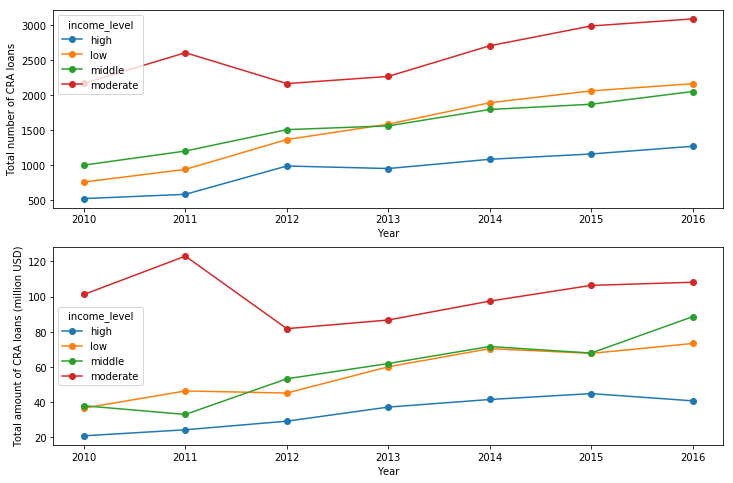

In [31]:
print('Reading full CRA data from backup...\n')
cra_data_by_tract_year_df = cra_data_by_tract_year_df_bk


fig1, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,8))
#fig, ax1 = plt.subplots(111, figsize=(8,4))

#fig = plt.subplots(111)

cra_data_by_tract_year_df.groupby(['activity_year','income_level'])['nLoansTotal'].sum().unstack().plot(ax=ax1, marker='o')#.plot(ax=ax1, marker='o')
cra_data_by_tract_year_df.groupby(['activity_year','income_level'])['amtLoansTotal'].sum().unstack().plot(ax=ax2, marker='o')#.plot(ax=ax1, marker='o')
#cra_data_by_tract_year_df.groupby(['activity_year','income_level'])['amtLoansTotal'].mean().unstack().plot(ax=ax2, marker='o')

ax1.set_xlabel('Year')
ax2.set_xlabel('Year')
#plt.ylabel('Total amount of CRA loans (million USD)')

ax2.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x)/1000000, ',.0f')))
ax1.set_ylabel('Total number of CRA loans')
ax2.set_ylabel('Total amount of CRA loans (million USD)')


plt.show()


Creating GeoDataFrame...
reading water features...


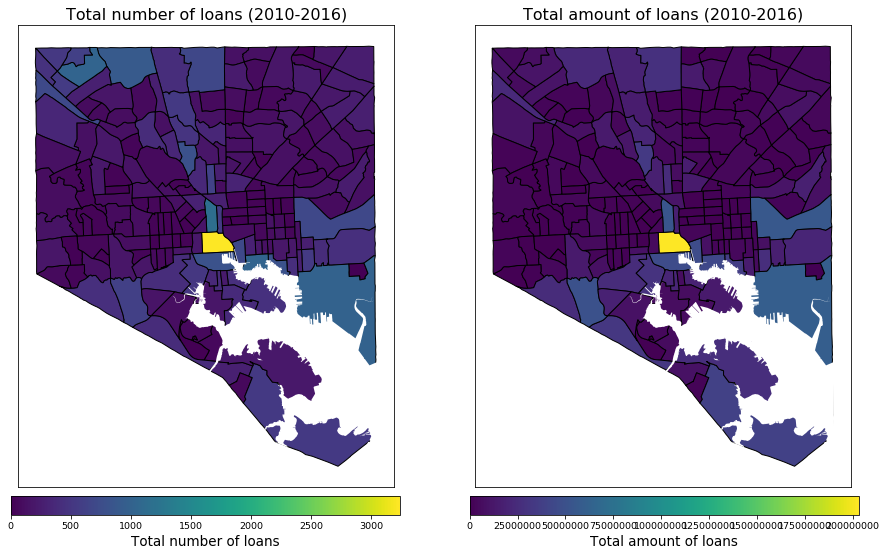

In [79]:
#cra_mapper_2016_df = cra_data_by_tract_year_df

# Sum total loans across all years
cra_loans_all_years_df = cra_data_by_tract_year_df.groupby('census_tract')[['nLoansTotal', 'amtLoansTotal']].sum()

# Add shapefile data
cra_loans_all_years_df = cra_loans_all_years_df.join(tract_shapes_gdf)
#cra_loans_all_years_df['geometry']
cra_loans_all_years_df = cra_loans_all_years_df[cra_loans_all_years_df['geometry'].notnull()]
#cra_loans_all_years_df


#tract_shapes_gdf.sort_index()
print('\nCreating GeoDataFrame...')
cra_loans_all_years_gdf = gpd.GeoDataFrame(data=cra_loans_all_years_df, crs=tract_shapes_gdf.crs, geometry='geometry')

# re-project to Maryland map
cra_loans_all_years_gdf = cra_loans_all_years_gdf.to_crs({'init': 'epsg:2248'})

scale = 0.25

fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(60*scale, 34*scale))

cra_loans_all_years_gdf.plot(ax=ax1, column='nLoansTotal', cmap='viridis', edgecolor='black')
cra_loans_all_years_gdf.plot(ax=ax2, column='amtLoansTotal', cmap='viridis', edgecolor='black')

ax1.set_title('Total number of loans (2010-2016)', fontsize=64*scale)
ax1.set_aspect('equal')

ax2.set_title('Total amount of loans (2010-2016)', fontsize=64*scale)
ax2.set_aspect('equal')

ax1.tick_params(axis='both', which='both', bottom=False, left=False, labelleft=False, labelbottom=False)
ax2.tick_params(axis='both', which='both', bottom=False, left=False, labelleft=False, labelbottom=False)


print('reading water features...')
water_gdf = gpd.read_file(shapefiledir+'water/water.shp', encoding='utf-8')
water_gdf = water_gdf.set_index('OBJECTID')
##water_gdf.sort_values('Shape_Area', ascending=False)
water_gdf.crs = cra_loans_all_years_gdf.crs
#water_gdf = water_gdf.to_crs(cra_loans_all_years_gdf.crs)

water_gdf[water_gdf['NAME'] == 'Harbor'].plot(ax=ax1, color='w')
water_gdf[water_gdf['NAME'] == 'Harbor'].plot(ax=ax2, color='w')

# add colorbar
cax1 = fig.add_axes([0.12, 0.08, 0.36, 0.03])
sm1 = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=0, vmax=cra_loans_all_years_gdf['nLoansTotal'].max()))

# fake up the array of the scalar mappable. Urgh...
sm1._A = []

cbar1 = fig.colorbar(sm1, cax=cax1, orientation='horizontal')
cax1.tick_params(labelsize=38*scale)
cbar1.set_label('Total number of loans', fontsize=54*scale)


# add colorbar
sm2 = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=0, vmax=cra_loans_all_years_gdf['amtLoansTotal'].max()))

# fake up the array of the scalar mappable. Urgh...
sm2._A = []

cax2 = fig.add_axes([0.545, 0.08, 0.36, 0.03])
cbar2 = fig.colorbar(sm2, cax=cax2, format='%.0f', orientation='horizontal')#ticks=np.arange(0, 300000, 50000), orientation='horizontal')
cax2.tick_params(labelsize=38*scale)
cbar2.set_label('Total amount of loans', fontsize=54*scale)

#water_gdf = water_gdf.to_crs(agg_tracts_gdf.crs)
#print(water_gdf.crs)
#water_gdf
#print('ok')
plt.show()

## Connect median family income data from ACS 5-year 2012-2016

In [ ]:
sorted(agg_tracts_df.sample(1).columns.tolist())


# DEPENDENT VARIABLES
# nLoans1, amtLoans1, etc.
# INDEPENDENT VARIABLES
# income_group_2016
# blk_afam, white, asian, amind_akna, nathaw_pac, hisp_lat
# occ_own
agg_tracts_gdf_bk = agg_tracts_gdf
print('afw')
#agg_tracts_df['housing']

In [ ]:
#agg_by_income_group_df = agg_by_income_group_df_bk
#agg_by_income_group_df = agg_tracts_df.groupby('income_group_code_2016')['amtLoansTotal'].sum()
#plt.scatter(agg_by_income_group_df)
agg_tracts_gdf = agg_tracts_gdf_bk
agg_tracts_gdf = agg_tracts_gdf.assign(amtLoansPerCapita = agg_tracts_gdf['amtLoansTotal'] / agg_tracts_gdf['population'])

income_groups_agg_gdf = agg_tracts_gdf.groupby('income_group_code_2016')['amtLoansPerCapita'].mean()
income_groups_agg_gdf = income_groups_agg_gdf.loc[0:13]
#income_groups_agg_df
#agg_tracts_df['amtLoansPerCapita'].sort_values(ascending=False)
#agg_tracts_df.sample(1).T
#agg_by_income_group_df.plot()

#ax1 = plt.scatter(income_groups_agg_gdf['income_group_code_2016'],income_groups_agg_gdf['amtLoansPerCapita'])
income_groups_agg_gdf.plot()
#plt.ylim([0,20000]) 

#agg_tracts_df.plot(['income_group_2016','amtLoansTotal'])
plt.show()
#agg_tracts_df.iloc[agg_tracts_df.loc['1501.0']]#sample(1).T#'2506.00']
#agg_tracts_gdf.sample(1).T




# Get ACS 5-year 2012-2016 data

In [ ]:
#!pip install --upgrade pip
#!pip install numpy
#!pip install pandas
#!pip install xlrd
import numpy as np
import pandas
from IPython.display import display, HTML
pandas.set_option('display.max_colwidth', -1)
basedir = '/home/idies/workspace/Temporary/raddick/census_scratch/'
vardir = basedir + 'variables/'
geodir = basedir + 'geography/'
datadir = basedir + 'data/'
errordir = basedir + 'error/'

extras_dir = '/home/idies/workspace/Storage/raddick/census/extras/'

# category can be one of: demographics, ancestry, residence, transportation... 
#      household, income, employment, housing, qa
category = 'demographics'


print('ok')

In [ ]:


print('Reading metadata...')
metadata_df = pandas.read_csv(vardir+'/variables_acs2017_{0:}.csv'.format(category), low_memory=False, index_col=0, encoding='utf-8')
metadata_df = metadata_df.drop('variable.1', axis=1)
geo_metadata_df = pandas.read_csv(geodir+'geo_variables_acs2017.csv', low_memory=False, index_col=0, encoding='utf-8')
geo_metadata_df = geo_metadata_df.set_index('variable')

print('Reading geography...')
geo_df = pandas.read_csv(geodir+'geo_acs2017.csv', low_memory=False, index_col=0, encoding='utf-8')

print('Reading data (estimates)...')
data_df = pandas.read_csv(datadir+'data_acs2017_{0:}.csv'.format(category), low_memory=False, index_col=0, encoding='utf-8')

print('Reading margins of error...')
error_df = pandas.read_csv(errordir+'error_acs2017_{0:}.csv'.format(category), low_memory=False, index_col=0, encoding='utf-8')

print('Calculating geography sumary levels...')
#data_df['SUMLEVEL'] = data_df['GEOID'].apply(lambda x: int(x[0:3]))
data_df = data_df.assign(SUMLEVEL = data_df['GEOID'].apply(lambda x: int(x[0:3])))
#data_df

print('Documenting geography summary levels...')
sumlevel_df = pandas.read_csv(extras_dir+'geo_summary_levels.csv', encoding='utf-8')
sumlevel_df = sumlevel_df.set_index('SUMLEVEL')
sumlevel_df



#print('Done!')
#sum

# GET GEODATA for ACS 2012-16 sumlevel = 140

In [ ]:
#baltimore_demographics_df = data_df
data_df[data_df['GEOID'] == '05000US24510'].T
#geo_df[(geo_df['STATE'] == 24) & (geo_df['COUNTY'] == 510)].T #05000US24510

In [ ]:
#geo_df.sample(1).T
geo_df[geo_df['SUMLEVEL'] == 140]#.sample(1).T

In [ ]:
print('Reading from backup...')
agg_tracts_gdf = agg_tracts_gdf_bk

print('reading MFI data...')
df = pandas.read_csv(thisdir+'/mfi_and_business_data/ACS_16_5YR_B19113_with_ann.csv', header=1)
df = df.assign(census_tract = pandas.to_numeric(df['Geography'].apply(lambda x: x.split(',')[0][12:])))
##outdir = '/home/idies/workspace/Storage/raddick/Baltimore/community_reinvestment_act/'
df = df.rename(columns={'Estimate; Median family income in the past 12 months (in 2016 inflation-adjusted dollars)': 'mfi'})
df = df.set_index('census_tract')
df.loc[df['mfi'] == '-', 'mfi'] = np.nan

print('assigning MFI to census tracts...')
agg_tracts_gdf = agg_tracts_gdf.assign(mfi = pandas.to_numeric(tract_shapes_gdf.join(df['mfi'], how='left')['mfi']))

print('backing up...')
agg_tracts_gdf_bk = agg_tracts_gdf

agg_tracts_gdf#.sample(3)


In [ ]:
scale = 1

fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(60*scale, 34*scale))

ax1 = agg_tracts_gdf.plot(ax=ax1, column='avgLoanAmount', cmap='viridis', edgecolor='black')
ax1.set_title('Average loan amount', fontsize=64*scale)
ax1.set_aspect('equal')
water_gdf[water_gdf['NAME'] == 'Harbor'].plot(ax=ax1, color='w')

for ix, thisrow in agg_tracts_gdf[agg_tracts_gdf['population'].notnull()].iterrows():
    annotator = str(ix)
    if (thisrow['population'] > 0):
        annotator += '\n' + '${0:,.0f}'.format(thisrow['avgLoanAmount'])
#        annotator += '\n' + '(n = {0:,.0f})'.format(thisrow['population'])
    ax1.annotate(annotator, 
                xy=(thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
                xytext=(thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
                ha='center', va='center', backgroundcolor='white', fontsize=11*scale)


ax2 = agg_tracts_gdf[agg_tracts_gdf['mfi'].notnull()].plot(ax=ax2, column='mfi', cmap='viridis', edgecolor='black')
ax2.set_title('Median family income', fontsize=64*scale)
ax2.set_aspect('equal')
water_gdf[water_gdf['NAME'] == 'Harbor'].plot(ax=ax2, color='w')

for ix, thisrow in agg_tracts_gdf[agg_tracts_gdf['mfi'].notnull()].iterrows():
    annotator = str(ix)
##    if (thisrow['population'] > 0):
    annotator += '\n' + '${0:,.0f}'.format(thisrow['mfi'])
        #annotator += '\n' + '(n = {0:,.0f})'.format(thisrow['population'])
    ax2.annotate(annotator, 
                xy=(thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
                xytext=(thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
                ha='center', va='center', backgroundcolor='white', fontsize=11*scale)

ax1.tick_params(axis='both', which='both', bottom=False, left=False, labelleft=False, labelbottom=False)
ax2.tick_params(axis='both', which='both', bottom=False, left=False, labelleft=False, labelbottom=False)

# add colorbar
cax1 = fig.add_axes([0.12, 0.08, 0.36, 0.03])
sm1 = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=0, vmax=agg_tracts_df['avgLoanAmount'].max()))

# fake up the array of the scalar mappable. Urgh...
sm1._A = []

cbar1 = fig.colorbar(sm1, cax=cax1, orientation='horizontal')
cax1.tick_params(labelsize=38*scale)
cbar1.set_label('Average loan amount', fontsize=54*scale)


# add colorbar
sm2 = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=0, vmax=220000))

# fake up the array of the scalar mappable. Urgh...
sm2._A = []

cax2 = fig.add_axes([0.545, 0.08, 0.36, 0.03])
cbar2 = fig.colorbar(sm2, cax=cax2, format='%.0f', ticks=np.arange(0, 300000, 50000), orientation='horizontal')
cax2.tick_params(labelsize=38*scale)
cbar2.set_label('Median Family Income', fontsize=54*scale)

#plt.show()

#print('Saving...')
#plt.savefig(figdir+'/baltimore_avg_loan_amount_with_mfi.svg', format='svg', dpi=300)
#print('DONE!')
plt.show()

In [ ]:
#agg_tracts_gdf.assign(avgLoanAmount = agg_tracts_gdf['amtLoansTotal'] / agg_tracts_gdf['nLoansTotal']).sample(1).T

In [ ]:
agg_tracts_gdf.sample(1).T[0:30]
#agg_tracts_gdf.groupby('activity_year').size()